<a href="https://colab.research.google.com/github/AunAli6783/python-/blob/main/label_face_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade


In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajaaunalikhan","key":"bc973bc712d8b5043a6c5aef67fe3256"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
import opendatasets as od

# paste the full Kaggle dataset URL
od.download("https://www.kaggle.com/datasets/atulanandjha/lfwpeople")


Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople


100%|██████████| 232M/232M [00:00<00:00, 807MB/s] 

In [ ]:
!tar -xvzf /content/lfwpeople/lfw-funneled.tgz -C /content/lfwpeople/


Streaming output truncated to the last 5000 lines.
lfw_funneled/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw_funneled/Delphine_Chuillot/
lfw_funneled/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw_funneled/Paul_LeClerc/
lfw_funneled/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw_funneled/Eddie_Jordan/
lfw_funneled/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw_funneled/Lionel_Richie/
lfw_funneled/Lionel_Richie/Lionel_Richie_0001.jpg
lfw_funneled/Lionel_Richie/Lionel_Richie_0002.jpg
lfw_funneled/Jose_Viegas_Filho/
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw_funneled/Roger_Mahony/
lfw_funneled/Roger_Mahony/Roger_Mahony_0001.jpg
lfw_funneled/Clay_Aiken/
lfw_funneled/Clay_Aiken/Clay_Aiken_0001.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0002.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0003.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0004.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0005.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0006.jpg
lfw_fun

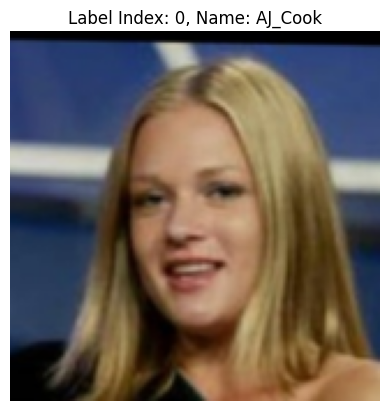

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader , random_split

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

dataset = ImageFolder(root='/content/lfwpeople/lfw_funneled', transform=transform)

# Optional: See one sample
import matplotlib.pyplot as plt
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label Index: {label}, Name: {dataset.classes[label]}")
plt.axis(False)
plt.show()


In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FaceCNN(nn.Module):
    def __init__(self, num_classes):
        super(FaceCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 38 * 38, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 38 * 38)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(dataset.classes)
model = FaceCNN(num_classes).to("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
!nvidia-smi

Thu Jul  3 11:23:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P0             27W /   70W |     170MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Train Accuracy: {accuracy:.2f}%")


Epoch 1, Loss: 1617.514, Train Accuracy: 18.43%
Epoch 2, Loss: 1233.013, Train Accuracy: 27.75%
Epoch 3, Loss: 835.534, Train Accuracy: 44.18%
Epoch 4, Loss: 520.342, Train Accuracy: 62.59%
Epoch 5, Loss: 303.528, Train Accuracy: 76.75%
Epoch 6, Loss: 180.437, Train Accuracy: 85.84%
Epoch 7, Loss: 103.887, Train Accuracy: 91.94%
Epoch 8, Loss: 69.264, Train Accuracy: 94.75%
Epoch 9, Loss: 64.444, Train Accuracy: 94.90%
Epoch 10, Loss: 54.217, Train Accuracy: 95.69%
Epoch 11, Loss: 51.349, Train Accuracy: 95.51%
Epoch 12, Loss: 54.175, Train Accuracy: 95.42%
Epoch 13, Loss: 43.952, Train Accuracy: 96.04%
Epoch 14, Loss: 28.960, Train Accuracy: 97.58%
Epoch 15, Loss: 35.516, Train Accuracy: 96.81%
Epoch 16, Loss: 34.706, Train Accuracy: 97.08%
Epoch 17, Loss: 28.934, Train Accuracy: 97.56%
Epoch 18, Loss: 31.874, Train Accuracy: 97.05%
Epoch 19, Loss: 36.413, Train Accuracy: 96.89%
Epoch 20, Loss: 26.250, Train Accuracy: 97.70%


In [21]:
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / len(val_loader.dataset)
print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 7.74%


In [23]:
from PIL import Image

# Load and preprocess image
img_path = "/content/lfwpeople/lfw_funneled/George_W_Bush/George_W_Bush_0001.jpg"
img = Image.open(img_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred = torch.argmax(output, dim=1).item()
    pred_name = dataset.classes[pred]
    print("Predicted Person:", pred_name)


Predicted Person: George_W_Bush


In [24]:

torch.save(model.state_dict(), 'face_cnn.pth')


model.load_state_dict(torch.load('face_cnn.pth'))


<All keys matched successfully>